# Problem description

In the last assignment, we created fully connected neural networks to
solve the task of classifying whether a ship is present in a satellite photo.

This assignment will address the same task, but using Convolutional Neural Network layers.


## Goal:

There are two notebook files in this assignment:
- **`Ships_in_satellite_images_P2.ipynb`**: First and only notebook you need to work on. Train your models and save them
- **`Model_test.ipynb`**: Used to test your results. After you complete the `Ships_in_satellite_images_P2.ipynb`, this notebook should be submitted

**Before you start working on this assignment, please check if your kernel is Python 3.7 (Right top of the page). If it is not Python 3.7, please go to `Kernel->Change kernel->Python 3.7` on the top**

In this notebook, you will need to create Sequential models in Keras *using Convolutional layers* to classify satellite photos.
- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

## Learning objectives
- Learn how to construct Neural Networks in a Keras Sequential model that uses Convolutional layer types.
- Appreciate how layer choices impact number of weights

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline

## Import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.0.0
Version 2, minor 0


# API for students

We have defined some utility routines in a file `nn_helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = nn_helper.Helper()`

- getData: Get a collection of labelled images, used as follows

  >`data, labels = helper.getData()`
- scaleData: scale your input data

  >`X, y = helper.scaleData(data, labels)`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`

In [2]:
## Load nn_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

import nn_helper
%aimport nn_helper

helper = nn_helper.Helper()

# Create the dataset

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/ships_in_satellite_images/data"
       
json_file =  "shipsnet.json"

# Get the data
data, labels = helper.getData(DATA_DIR, json_file)
n_samples, width, height, channel = data.shape
print("Date shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))

Date shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


In [4]:
# Shuffle the data
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Examine the image/label pairs
We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.


Text(0.5, 0.98, 'Label: 0')

/home/kjp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


Text(0.5, 0.98, 'Label: 1')

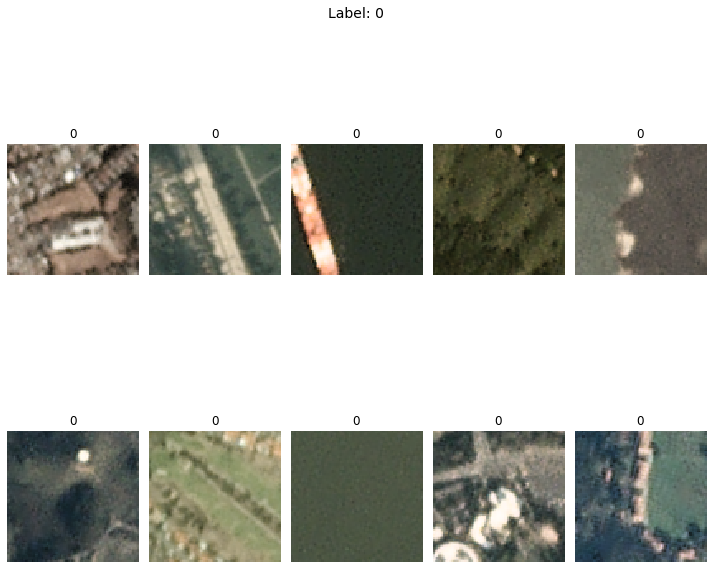

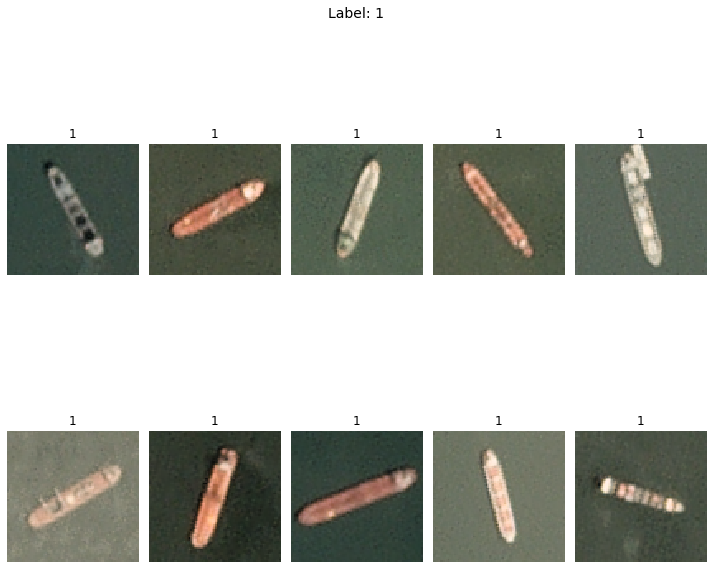

In [5]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data[ labels == lab ], labels[ labels == lab]
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ])
    fig.suptitle("Label: "+  str(lab), fontsize=14)
    fig.show()
    print("\n\n")

# Make sure the features are in the range [0,1]  

Just as in our prior assignment: we need to
- Scale the image data so that
pixel values are in the range between 0 and 255
- One Hot Encode the labels

Hopefully you have done this on your own in the prior assignment.
We will do it for you below.

In [6]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
X, y = np.array([]), np.array([])
X, y = helper.scaleData(data, labels)

print('X shape: ', str(X.shape))
print('y.shape: ', str(y.shape))
print(y[0])

X shape:  (4000, 80, 80, 3)
y.shape:  (4000, 2)
[0. 1.]


# Split data into training data and testing data

To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell



In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for further testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Create a simple CNN model 

**Question:** Create a Keras Sequential model:
- With a single Convolutional Layer providing 32 features
    - You may choose your own kernel size
    - Use full padding
- Feeding a head layer implementing Classification  

Please name your Convolutional layer "CNN_1" and your Dense layer (head layer) "dense_head"

**Hints:**
- The `input shape` argument of the first layer should be the shape of a single example, which should be 3-dimensional. We don't need to flatten the data before feeding the Convolutional layer.
- What is the shape of the output of the Convolutional Layer ? What should be the shape of the input to the Classification head ?
    - You may want to flatten the output of the Convolutional layer before feeding the Classification head.


In [8]:
# Get the number of unique labels
num_cases = np.unique(labels).shape[0]

# Set model0 equal to a Keras Sequential model
model0 = None

### BEGIN SOLUTION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

model0 = Sequential()
model0.add(Conv2D(32, (3, 3), padding="same", input_shape=X.shape[1:], activation='relu', name='CNN_1'))
model0.add(Flatten())
model0.add(Dropout(0.2))
model0.add(Dense(num_cases, activation='softmax', name='dense_head'))
### END SOLUTION

model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dropout (Dropout)            (None, 204800)            0         
_________________________________________________________________
dense_head (Dense)           (None, 2)                 409602    
Total params: 410,498
Trainable params: 410,498
Non-trainable params: 0
_________________________________________________________________


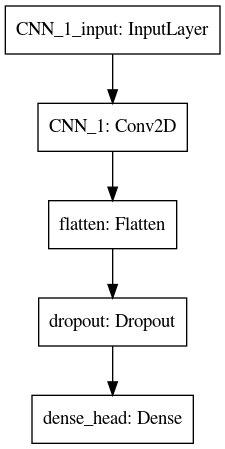

In [9]:
# Plot your model
plot_model(model0)

## Train model


**Question:** Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: `categorical_crossentropy`; Metric: "accuracy"
- Use exactly 10  epochs for training
- Save your training results in a variable named `history`
- Plot your training results using the`plotTrain` method described in the Student API above.


Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 11s 4ms/sample - loss: 0.7351 - accuracy: 0.8528 - val_loss: 0.1585 - val_accuracy: 0.9458
Epoch 2/10
2880/2880 [==============================] - 10s 3ms/sample - loss: 0.1959 - accuracy: 0.9285 - val_loss: 0.1453 - val_accuracy: 0.9389
Epoch 3/10
2880/2880 [==============================] - 11s 4ms/sample - loss: 0.1641 - accuracy: 0.9392 - val_loss: 0.3007 - val_accuracy: 0.8903
Epoch 4/10
2880/2880 [==============================] - 11s 4ms/sample - loss: 0.1202 - accuracy: 0.9566 - val_loss: 0.3731 - val_accuracy: 0.8889
Epoch 5/10
2880/2880 [==============================] - 11s 4ms/sample - loss: 0.1022 - accuracy: 0.9674 - val_loss: 0.1199 - val_accuracy: 0.9542
Epoch 6/10
2880/2880 [==============================] - 10s 4ms/sample - loss: 0.1284 - accuracy: 0.9632 - val_loss: 0.2349 - val_accuracy: 0.9236
Epoch 7/10
2880/2880 [==============================] - 12s 4ms/sample 

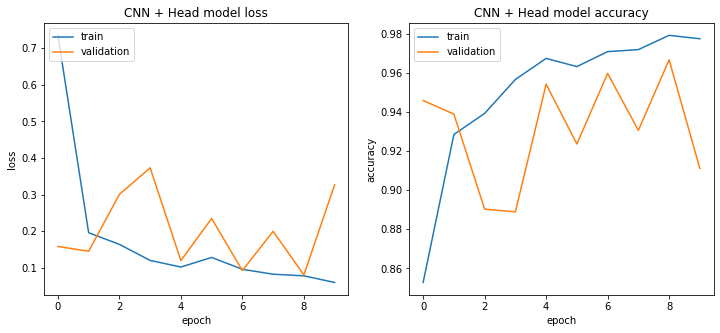

In [10]:
model_name0 = "CNN + Head"

### BEGIN SOLUTION
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model0.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = model0.fit(X_train_, y_train_, epochs=10, validation_data=(X_val_, y_val_))
fig, axs = helper.plotTrain(history, model_name0)
### END SOLUTION


**Expected outputs (your model may produce similar although not identical results):** 
<table> 
    <tr> 
        <td>  
            Training accuracy
        </td>
        <td>
         0.9760
        </td>
    </tr>
    <tr> 
        <td>
            Validation accuracy
        </td>
        <td>
         0.9333
        </td>
    </tr>

</table>

The graphs of your loss and accuracy curves:
<img src='./images/CNN_model_loss_accuracy.png' style='width:600px;height:300px;'>

We can see that, compared to the prior assignment's model that used *only* a Classification head,
adding a CNN layer really seems to help to reduce loss and increase accuracy.



## How many weights in the model ?

**Question:** Calculate the number of parameters in your model.  

**Hint:** You can use the model's `count_params()` method.

In [11]:
# Set num_parameters2 equal to the number of weights in the model
num_parameters0 = None

### BEGIN SOLUTION
num_parameters0 = model0.count_params()
### END SOLUTION

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  410498


## Evaluate the model


**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.

In [12]:
score0 = []

### BEGIN SOLUTION
score0 = model0.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

CNN + Head: Test loss: 0.33 / Test accuracy: 0.93


Your test accuracy should be around 0.9

## Save the trained model0 and history for submission

In [13]:
helper.saveModel(model0, model_name0)
helper.saveModelNonPortable(model0, model_name0)
helper.saveHistory(history, model_name0)

Model saved in directory ./models/CNN + Head; create an archive of this directory and submit with your assignment.
Directory ./models/CNN + Head already exists, files will be over-written.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/CNN + Head/assets
Model saved in directory ./models/CNN + Head; create an archive of this directory and submit with your assignment.
Directory ./models/CNN + Head already exists, files will be over-written.


In [14]:
## Restore the model (make sure that it works)
model_loaded = helper.loadModel(model_name0)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a model with 4 Convolutional layers

**Question:** 

We will now create a model with more Convolutional layers.
- Use **4** Convolutional layers.
    - You may choose your own kernel size
    - Use full padding
    - ReLU activation functions for the Convolutional layers

    - The first two Convolutional layers should have 32 features each.
        - Please name thee layers "CNN_1" and "CNN_2"
    - The last two Convolutional layers should have 64 features each.
        - Please name thee layers "CNN_3" and "CNN_4"
- Insert a `MaxPooling` layer after every two Convolutional layers (e.g., after CNN_2 and CNN_4)
    - to reduce each spatial dimension by a factor of 2  

- Please name your head layer "dense_head". 

**Hints:**
- Don't forget to flatten the output of the layer feeding the Classification head 
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 


In [15]:
# Set model3 equal to a Keras Sequential model
model1 = None

### BEGIN SOLUTION
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding="same", input_shape=(80, 80, 3), activation='relu', name='CNN_1'))
model1.add(Conv2D(32, (3, 3), padding="same", activation='relu', name='CNN_2'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, (3, 3), padding="same", activation='relu', name='CNN_3'))
model1.add(Conv2D(64, (3, 3), padding="same", activation='relu', name='CNN_4'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(num_cases, activation='softmax', name='dense_head'))
### END SOLUTION

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CNN_1 (Conv2D)               (None, 80, 80, 32)        896       
_________________________________________________________________
CNN_2 (Conv2D)               (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
CNN_3 (Conv2D)               (None, 40, 40, 64)        18496     
_________________________________________________________________
CNN_4 (Conv2D)               (None, 40, 40, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)       

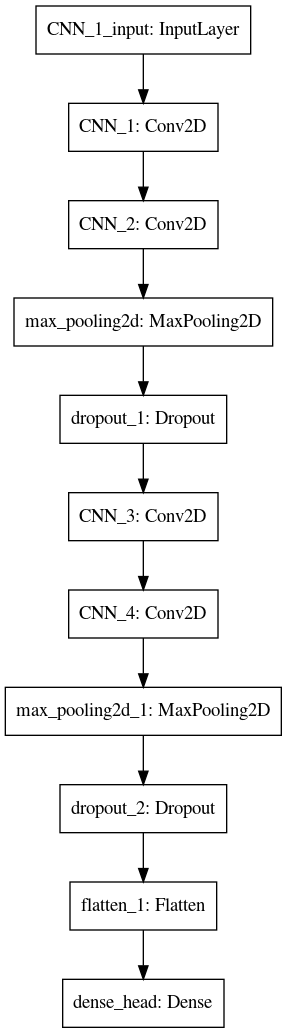

In [16]:
# Plot your model
plot_model(model1)

## Train model

**Question:**

Train your new model following the same instructions as given for training the first model.
- **Except**: Save your training results in a variable named `history1`



Train on 2880 samples, validate on 720 samples
Epoch 1/10
2880/2880 [==============================] - 18s 6ms/sample - loss: 0.4413 - accuracy: 0.8111 - val_loss: 0.1913 - val_accuracy: 0.9292
Epoch 2/10
2880/2880 [==============================] - 20s 7ms/sample - loss: 0.2182 - accuracy: 0.9142 - val_loss: 0.1933 - val_accuracy: 0.9306
Epoch 3/10
2880/2880 [==============================] - 17s 6ms/sample - loss: 0.1742 - accuracy: 0.9368 - val_loss: 0.1262 - val_accuracy: 0.9542
Epoch 4/10
2880/2880 [==============================] - 16s 6ms/sample - loss: 0.1392 - accuracy: 0.9524 - val_loss: 0.1005 - val_accuracy: 0.9556
Epoch 5/10
2880/2880 [==============================] - 19s 7ms/sample - loss: 0.0974 - accuracy: 0.9646 - val_loss: 0.0712 - val_accuracy: 0.9750
Epoch 6/10
2880/2880 [==============================] - 19s 6ms/sample - loss: 0.0820 - accuracy: 0.9691 - val_loss: 0.0695 - val_accuracy: 0.9722
Epoch 7/10
2880/2880 [==============================] - 21s 7ms/sample 

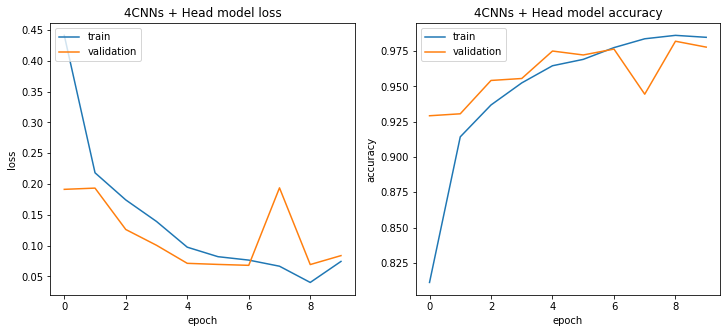

In [17]:
# Train the model using the API
model_name1 = "4CNNs + Head"

### BEGIN SOLUTION
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train_, y_train_, epochs=10, validation_data=(X_val_, y_val_))
fig, axs = helper.plotTrain(history1, model_name1)
### END SOLUTION

**Expected outputs (there may be some differences):**  
<table> 
    <tr> 
        <td>  
            Training accuracy
        </td>
        <td>
         0.9903
        </td>
    </tr>
    <tr> 
        <td>
            Validation accuracy
        </td>
        <td>
         0.9750
        </td>
    </tr>

</table>

The graphs of your loss and accuracy curves:
<img src='./images/4CNNs_model_loss_accuracy.png' style='width:600px;height:300px;'>

Hopefully, your new model will have improved Loss and Accuracy metrics compared to your first model.


## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

In [18]:
# Set num_parameters3 equal to the number of weights in the model
num_parameters1 = None

### BEGIN SOLUTION
num_parameters1 = model1.count_params()
### END SOLUTION

print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 116770


## Evaluate the model

Evaluate your new model following the same instructions as given for evaluating the first model.
- **Except**: store the model score in a variable named `score1`.  



In [19]:
score1 = []

### BEGIN SOLUTION
score1 = model1.evaluate(X_test, y_test, verbose=0)
### END SOLUTION

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

4CNNs + Head: Test loss: 0.10 / Test accuracy: 0.97


Your test accuracy should be higher than before

# Save your trained model1 and history1

In [20]:
helper.saveModel(model1, model_name1)
helper.saveModelNonPortable(model1, model_name1)
helper.saveHistory(history1, model_name1)

Model saved in directory ./models/4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory ./models/4CNNs + Head already exists, files will be over-written.
INFO:tensorflow:Assets written to: ./models/4CNNs + Head/assets
Model saved in directory ./models/4CNNs + Head; create an archive of this directory and submit with your assignment.
Directory ./models/4CNNs + Head already exists, files will be over-written.


## Your own model (Optional)

Now you can build your own model using what you have learned from the course. Some ideas to try:
- Change the kernel size in Convolutional layers
- Change the number of features of Convolutional layers
- Experiment with different pooling layers: `MaxPooling2D` and `AveragePooling2D`
- Change the activation function

Observe the effect of each change on the Loss and Accuracy.


## Now Submit your assignment!
Please click on the blue button <span style="color: blue;"> **Submit** </span> in this notebook. 